In [77]:
import time
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache
import numpy as np

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

# from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
# from utils import *
import matplotlib.pyplot as plt
# import math

%matplotlib inline

In [85]:

current_date = datetime.datetime.now()
current_date_formatted = current_date.strftime("%Y-%m-%d")
first_day_of_year_formatted = datetime.datetime(current_date.year,1,1).strftime("%Y-%m-%d")
class Stock:
    def __init__(self, ticker,df=None,initial_capital=1000, path=r"/Users/lucasmoyer/development/two-dolla/stocks.pkl", save_new = False,debug=False):
        self.ticker = ticker
        self.initial_capital = initial_capital
        self.isBankrupt = 0
        self.path = path
        self.savedBars = None
        self.positionOutCash = False
        self.strategies = []
        self.debug = debug
        self.save_new = save_new

        
        with open(self.path, 'rb') as handle:
            self.savedBars = pickle.load(handle)
        self.df = df
        if (self.df == None or save_new):
            print('getting new data')
            
            self.df = self.getStocksData(ticker,save_new=True)
        
        self.bars = self.df
        self.positions = pd.DataFrame(self.df.index)
       
        
        # print("bars")
        # print(self.bars)

    def getSavedData(self, ticker):
        with open(self.path, 'rb') as handle:
            stocks = pickle.load(handle)
            if self.ticker in stocks:
                return stocks[self.ticker]
            else:
                return None



    # gets stock ticket data for current day going back days_back
    def getStocksData(self,tickers, start=current_date_formatted, end=first_day_of_year_formatted, save_new=False, saveToCSV=True):
        
        def convert_time(epoch):
            return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

        epoch_time = int(time.time())
        day_epoch = 60*60*24
        # check if data exists, if not pull data
        if (self.save_new or self.ticker not in self.savedBars):
            
            try:
                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                if (self.debug):
                    print(f"Trying download of {self.ticker}")
                stock_data =  pdr.get_data_yahoo(self.ticker, start=start,end=end,session=session)
                stock_data = stock_data.reset_index()
                if (self.debug):
                    print(f"Downloaded bars of {self.ticker}")
                if saveToCSV:
                    path = "/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs"
                    stock_data.to_csv(f'{path + "/" + self.ticker}.csv', index = False, encoding='utf-8') 
                self.savedBars[self.ticker] = stock_data
                with open(self.path, 'wb') as handle:
                    pickle.dump(self.savedBars, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
                return stock_data
            except:
                print("Skipping stock for {}, bad data :<".format(self.ticker))
        else:
            return self.savedBars[self.ticker]

    
    def addStrategy(self, func):
        self.strategies.append(func)

    def viewStrategies(self):
        for x in self.strategies:
            print(x)

    def backtest(self):
        # macd1 = 500 * self.macd(self.df, 12, 23)
        # macd2 = self.macd(self.df, 12, 43)
        # macd3 = self.macd(self.df, 12, 53)
        # strat1 = pd.DataFrame(self.bars.index)

        # strat1 = pd.Series(500, index=self.bars.index)
        strategies = self.strategies

        self.positions[self.ticker + '_position'] = pd.concat(strategies).groupby(level=0).mean()
        self.positions[self.ticker + '_position'].at[0] = 0
        self.positions[self.ticker + '_open'] = self.bars.Open
        self.positions[self.ticker + '_close'] = self.bars.Close
        self.positions['date'] = self.bars.Date

        self.positions[self.ticker + '_pos_diff'] = self.positions[self.ticker + "_position"].diff()

        self.positions[self.ticker + "_cash_needed"] = self.positions[self.ticker + "_pos_diff"] * self.bars.Open
        self.positions[self.ticker + "_cash"] = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'].cumsum()
        self.positions[self.ticker + "_holdings"] = 0
        self.positions[self.ticker + "_pos_diff"].at[0] = 0
        self.positions.at[0, f"{self.ticker}_cash"] = self.initial_capital


        cash_held = self.initial_capital
        available_cash = self.initial_capital

        for index, row in self.positions.iterrows():
            if index == 0:
                continue

            price = row[self.ticker + "_open"]
            cash = self.positions.loc[index - 1][self.ticker + "_cash"]
            holdings = self.positions.loc[index - 1][self.ticker + "_holdings"]
            position = self.positions.loc[index][self.ticker + '_position']
            pos_diff = self.positions.loc[index][self.ticker + '_position'] - self.positions.loc[index - 1][self.ticker + '_position']
            cash_needed = pos_diff * price
            if (self.debug):
                print(f"For index: {index}")
                print(f"previous position {self.positions.loc[index - 1][self.ticker + '_position']}")
                print(f"price {price}")
                print(f"previous cash {cash}")
                print(f"strategy position {position}")
                print(f"cash needed: {cash_needed}")


            if (cash > cash_needed) and (not self.positionOutCash):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"Making trade: Cash = {cash}")
                # holdings = holdings + cash_needed
               
            # is there enough cash
            elif (cash_needed < 0):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"cash added from short {cash}")
                if (cash > (position * price)):
                    self.positionOutCash = False
                    if (self.debug):
                        print(f"position is back in range {index, (position *price)}")
            else:
                if (self.debug):
                    print("ran out of money")
                if (index == 1):
                    self.positions.at[index, f"{self.ticker}_position"] = cash / price
                    if (self.debug):
                        print(f"setting first index position {cash} {price} {cash/price}")
                else:
                    self.positions.at[index, f"{self.ticker}_position"] = self.positions.at[index -1, f"{self.ticker}_position"]  
                    if (self.debug):
                        print("setting position to prev position")         
                # holdings = holdings + cash # spending all the cash

                self.positionOutCash = True
                cash = 0
                if (self.debug):
                    print(f"postion {self.positions.at[index, f'{self.ticker}_position']}")

            # self.positions.at[index, f"{self.ticker}_holdings"] = holdings

            self.positions.at[index, f"{self.ticker}_cash"] = cash

        self.positions[f'{self.ticker}_holdings'] = self.positions[f"{self.ticker}_position"] * self.positions[f"{self.ticker}_open"]
        self.positions['total'] = self.positions[f"{self.ticker}_cash"] + self.positions[f"{self.ticker}_holdings"]

        self.positions = self.positions.round(2)

        # self.positions.plot(x=f'date', y='total')
        return self.positions
        # self.positions.total.gcf()
    def plotBackTest(self):
        self.positions.plot(x=f'date', y='total')

    ### STRATEGIES ###
    def macd(self, short=12, long=26):
        df = self.df
        exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
        exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_norm'] = (df['macd'] - df['macd'].min()) / (df['macd'].max() - df['macd'].min())
        return df['macd_norm']
    
    def buyStock(self, amount):
        return pd.Series(amount, index=self.bars.index)


class Portfolio:
    def __init__(self,initial_capital=1000,debug=False):
        self.stocks = []
        self.debug = debug
        self.backtest_df = None
        self.initial_capital = initial_capital

    # either takes ticker or Stock
    def addStock(self,stock_instance):
        if isinstance(stock_instance, str):
            # If the input is a string (ticker), fetch data and create a Stock object
            # stock_data = self.fetch_stock_data(input_stock)
            # new_stock = Stock(input_stock, stock_data)
            stock = Stock(stock_instance,df=None, save_new=True,debug=False)
            self.stocks.append(stock)
        elif isinstance(stock_instance, Stock):
            self.stocks.append(stock_instance)

    def get_by_ticker(self, ticker):
        for stock in self.stocks:
            if (stock.ticker == ticker):
                return stock
                break
        return None

    def markowitz(self, weight=1):
       
        # df = pd.DataFrame(index=first_stock.df[next(iter(first_stock.df))].index)

        self.addReturns()
        port_returns = pd.DataFrame()
        for stock in self.stocks:
            port_returns[stock.ticker] = stock.df['simple_returns']
        risk_free = 0
        markov_runs = 100

        markov_data = pd.DataFrame(columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(self.stocks))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            # df = df.append(row, ignore_index=True)
            # df = df.concat([df,row])
            markov_data = pd.concat([markov_data, pd.DataFrame.from_records([row])])
        markov_data["sharpe"] = (markov_data["return"] - risk_free) / markov_data["volatility"]

        MSR = markov_data.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = markov_data.sort_values(by=["volatility"], ascending=True).head(1)
        weights = {}
        for index, x in enumerate(list(MSR['weights'])[0]):
            weights[self.stocks[index].ticker] = x * weight
            stock_instance = self.get_by_ticker(self.stocks[index].ticker)
            stock_instance.addStrategy(stock_instance.buyStock(x * weight))
            # self.get_by_ticker(self.stocks[index].ticker).addStrategy()
        return weights


    def addReturns(self):
        for stock in self.stocks:
            stock.df['simple_returns'] = stock.df['Adj Close'].pct_change()
            stock.df['log_returns'] = np.log(stock.df['Adj Close'] + 1)
            stock.df['cum_daily_return'] = ((1 + stock.df['simple_returns']).cumprod() - 1)
            stock.df = stock.df.dropna()

    def backtest(self, plot=False):
        ticker_list = []
        self.backtest_df = pd.DataFrame(self.stocks[0].df.Date)
        # return backtest_df
        for stock in self.stocks:
            stock.backtest()
            ticker_list.append(stock.ticker)
            self.backtest_df[stock.ticker] = stock.positions.total
        # result = pd.concat(totals)
        self.backtest_df['total'] = self.backtest_df[ticker_list].sum(axis=1)

        if (plot):
            self.plotBacktest()
        return self.backtest_df
    
    def plotBacktest(self):
        self.backtest_df.plot(x=f'Date', y='total')
    

def getRandomWeights(numstocks):
    weights = np.random.rand(numstocks)
    return (weights/np.sum(weights))

def getPortWeightedReturns(port_ret, weights):
    assert(len(port_ret.columns) == len(weights))
    return port_ret.iloc[:, 0:len(weights)].mul(weights, axis=1).sum(axis=1)

def getPortWeightedAnnualReturn(port_ret, weights):
    returns = getPortWeightedReturns(port_ret, weights)

    mean_return_daily = np.mean(returns)
    # Calculate the implied annualized average return
    mean_return_annualized = ((1+mean_return_daily)**252)-1
    return(mean_return_annualized)

def getPortWeightedVol(port_ret, weights):
    cov_mat = port_ret.cov()
    #cov_mat_annual = cov_mat * 252
    # cov_mat_annual
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    return port_vol



getting new data
getting new data


,0,AAPL_position,AAPL_open,AAPL_close,date,AAPL_pos_diff,AAPL_cash_needed,AAPL_cash,AAPL_holdings,total
0,0,0.00,130.28,125.07,2023-01-03,0.0,NaN,1000.0,0.00,1000.00
1,1,7.88,126.89,126.36,2023-01-04,15.0,1903.35,0.0,1000.00,1000.00
2,2,7.88,127.13,125.02,2023-01-05,0.0,0.00,0.0,1001.89,1001.89
3,3,7.88,126.01,129.62,2023-01-06,0.0,0.00,0.0,993.06,993.06
4,4,7.88,130.47,130.15,2023-01-09,0.0,0.00,0.0,1028.21,1028.21
...,...,...,...,...,...,...,...,...,...,...
162,162,7.88,177.38,178.61,2023-08-25,0.0,0.00,0.0,1397.90,1397.90
163,163,7.88,180.09,180.19,2023-08-28,0.0,0.00,0.0,1419.26,1419.26
164,164,7.88,179.70,184.12,2023-08-29,0.0,0.00,0.0,1416.19,1416.19
165,165,7.88,184.94,187.65,2023-08-30,0.0,0.00,0.0,1457.48,1457.48


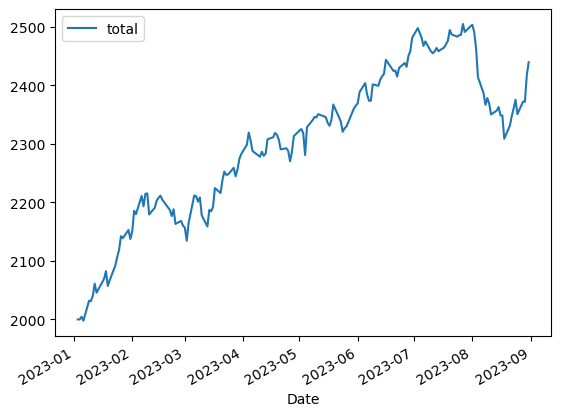

In [3]:
stock_T = Stock('T',df=None, save_new=False,debug=False)
stock_T.addStrategy(stock_T.buyStock(10))
stock_AAPL = Stock('AAPL',df=None, save_new=False,debug=False)
stock_AAPL.addStrategy(stock_AAPL.buyStock(15))

portfolio_instance = Portfolio()
portfolio_instance.addStock(stock_T)
portfolio_instance.addStock(stock_AAPL)

portfolio_instance.backtest()
portfolio_instance.plotBacktest()

portfolio_instance.stocks[1].positions


getting new data
getting new data
getting new data


,Date,T,AAPL,total
1,2023-01-04,1000.00,1000.00,2000.00
2,2023-01-05,1000.01,1000.23,2000.24
3,2023-01-06,1000.01,999.15,1999.16
4,2023-01-09,1000.01,1003.48,2003.49
5,2023-01-10,1000.01,1003.27,2003.28
...,...,...,...,...
162,2023-08-25,999.86,1049.02,2048.88
163,2023-08-28,999.86,1051.65,2051.51
164,2023-08-29,999.87,1051.27,2051.14
165,2023-08-30,999.88,1056.36,2056.24


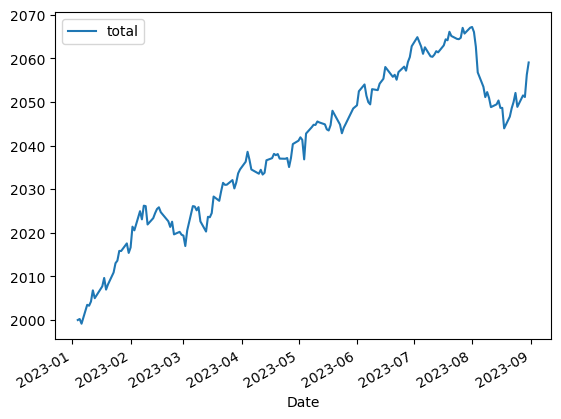

In [86]:
stock_T = Stock('T',df=None, save_new=False,debug=False)
# # stock_T.addStrategy(stock_T.buyStock(10))
# stock_AAPL = Stock('AAPL',df=None, save_new=False,debug=False)
# # stock_AAPL.addStrategy(stock_AAPL.buyStock(15))

portfolio_instance = Portfolio()
portfolio_instance.addStock('T')
portfolio_instance.addStock('AAPL')

portfolio_instance.markowitz()
portfolio_instance.backtest(plot=True)
# first_stock = portfolio_instance.stocks[0]
# df = pd.DataFrame(index=first_stock.df[next(iter(first_stock.df))].index)

In [65]:
# Example usage
# df = ...  # Load your DataFrame here
initial_capital = 1000
ticker = 'T'

stock_instance = Stock(ticker,df=None,initial_capital = initial_capital, save_new=False,debug=False)
# stock_instance.addStrategy(500*stock_instance.macd())
stock_instance.addStrategy(stock_instance.buyStock(10))
stock_instance.addStrategy(stock_instance.macd(1,15))
# stock_instance.addStrategy(stock_instance.macd(13,26))
stock_instance.backtest()



# stock_instance.viewStrategies()
# stock_instance.strategies

,0,T_position,T_open,T_close,date,T_pos_diff,T_cash_needed,T_cash,T_holdings,total
0,0,0.00,18.51,18.74,2023-01-03,0.00,NaN,1000.00,0.00,1000.00
1,1,5.35,18.87,19.14,2023-01-04,5.35,101.00,899.00,101.00,1000.00
2,2,5.36,19.14,19.21,2023-01-05,0.00,0.06,898.95,102.50,1001.45
3,3,5.40,19.35,19.53,2023-01-06,0.04,0.80,898.15,104.42,1002.57
4,4,5.35,19.24,19.04,2023-01-09,-0.05,-0.89,899.04,102.94,1001.98
...,...,...,...,...,...,...,...,...,...,...
162,162,5.28,14.17,14.11,2023-08-25,-0.01,-0.07,901.59,74.75,976.33
163,163,5.29,14.18,14.21,2023-08-28,0.02,0.26,901.33,75.06,976.39
164,164,5.38,14.45,14.77,2023-08-29,0.09,1.30,900.03,77.79,977.82
165,165,5.37,14.88,14.73,2023-08-30,-0.02,-0.27,900.30,79.83,980.13
